# Models

And now - this colab unveils the heart (or the brains?) of the transformers library - the models:

This should run nicely on a low-cost or free T4 box.

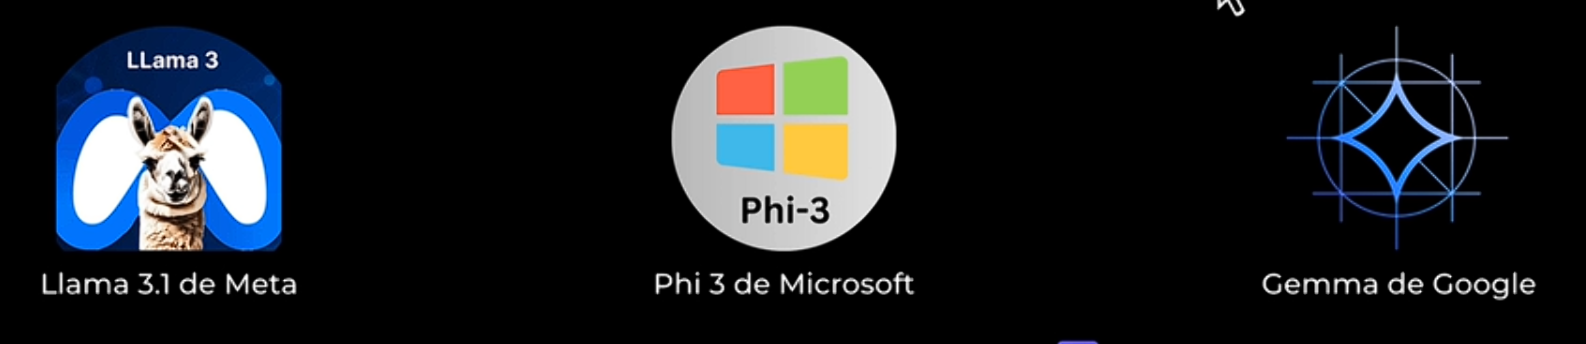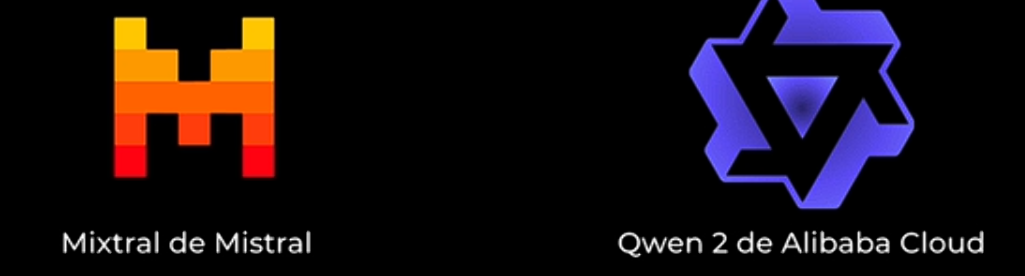

In [ ]:
!pip install requests torch bitsandbytes transformers sentencepiece accelerate
#!pip install -U bitsandbytes

In [2]:
from google.colab import userdata
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM, TextStreamer, BitsAndBytesConfig
import torch

Inicia Sesión en Hugging Face.

In [9]:
hf_token = userdata.get('HUGGINGFACE_API_KEY')
# Remove 'Bearer ' prefix if present, as login expects the raw token
if hf_token and hf_token.startswith('Bearer '):
    hf_token = hf_token.replace('Bearer ', '')
# Strip any leading/trailing whitespace that might have been accidentally included
if hf_token:
    hf_token = hf_token.strip()
#login(hf_token, add_to_git_credential_=True)

In [10]:
login(hf_token)

In [11]:
# Modelos a utilizar.

LLAMA = "meta-llama/Llama-3.1-8B-Instruct"
PHI4 = "microsoft/Phi-3-mini-4k-instruct"
GEMMA3 = "google/gemma-3-4b-it"
QWEN = "Qwen/Qwen3-4B-Instruct-2507"
MIXTRAL = "mistralai/Mixtral-8x7B-Instruct-v0.1"

In [12]:
content_system = "Eres un asistente util"
content_user = "Cuentame un chiste divertido para una sala llena de cientificos de datos"

messages = [
    {"role": "system", "content": content_system},
    {"role": "user", "content": content_user}
]

print(messages)

[{'role': 'system', 'content': 'Eres un asistente util'}, {'role': 'user', 'content': 'Cuentame un chiste divertido para una sala llena de cientificos de datos'}]


**Acceder a Llama desde Meta.**

Para poder usar Llama, meta requiere que se firmen los terminos de servicio.

[Repositorio Llama](https://huggingface.co/collections/meta-llama/metas-llama-31-models-and-evals)


In [13]:
# Quantization config - Esto permite cargar el modelo en la memoria y utilizar menos memoria
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,    # Se cargaran en 4 bits
    bnb_4bit_use_double_quant=True,   # Cuantifica los pesos 2 veces.
    bnb_4bit_compute_dtype=torch.bfloat16, # Los productos y operaciones tienen 16 bits
    bnb_4bit_quant_type="nf4"
)

In [14]:
# Tokenizer

tokenizer = AutoTokenizer.from_pretrained(LLAMA)
tokenizer.pad_token = tokenizer.eos_token
inputs = tokenizer.apply_chat_template(messages, return_tensors="pt").to("cuda")


In [15]:
# The model

model = AutoModelForCausalLM.from_pretrained(LLAMA, device_map="auto", quantization_config=quant_config)

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [16]:
memory = model.get_memory_footprint() / 1e6
print(f"Memory footprint: {memory:,.1f} MB")
#

Memory footprint: 5,591.5 MB


In [17]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRM

In [18]:
outputs = model.generate(inputs, max_new_tokens=80)
print(tokenizer.decode(outputs[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

Eres un asistente util<|eot_id|><|start_header_id|>user<|end_header_id|>

Cuentame un chiste divertido para una sala llena de cientificos de datos<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Un científico de datos entra en un bar y ordena un cóctel. Cuando se lo traen, le dicen que cuesta $5. Él pregunta: "¿Por qué no me cobran solo por la información útil?"<|eot_id|>
